<a href="https://colab.research.google.com/github/dostirathi031/3D_BrickBreaker_Game/blob/master/inception_v3_model_final_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import os
import pandas as pd
import numpy as np
import keras
import warnings

warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)


In [ ]:
MildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())


                                           filepaths         labels
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [ ]:
Alzheimer_df.shape

(33984, 2)

In [ ]:
train_images, test_images = train_test_split(
    Alzheimer_df, test_size=0.3, random_state=42, stratify=Alzheimer_df['labels']
)
train_set, val_set = train_test_split(
    train_images, test_size=0.2, random_state=42, stratify=train_images['labels']
)


In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(19030, 2)
(10196, 2)
(4758, 2)
(23788, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=32,
                                      shuffle=True
                                     )
test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle=False
                                    )
val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 19030 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 4758 validated image filenames belonging to 4 classes.


In [ ]:
classes = list(train.class_indices.keys())
print(classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

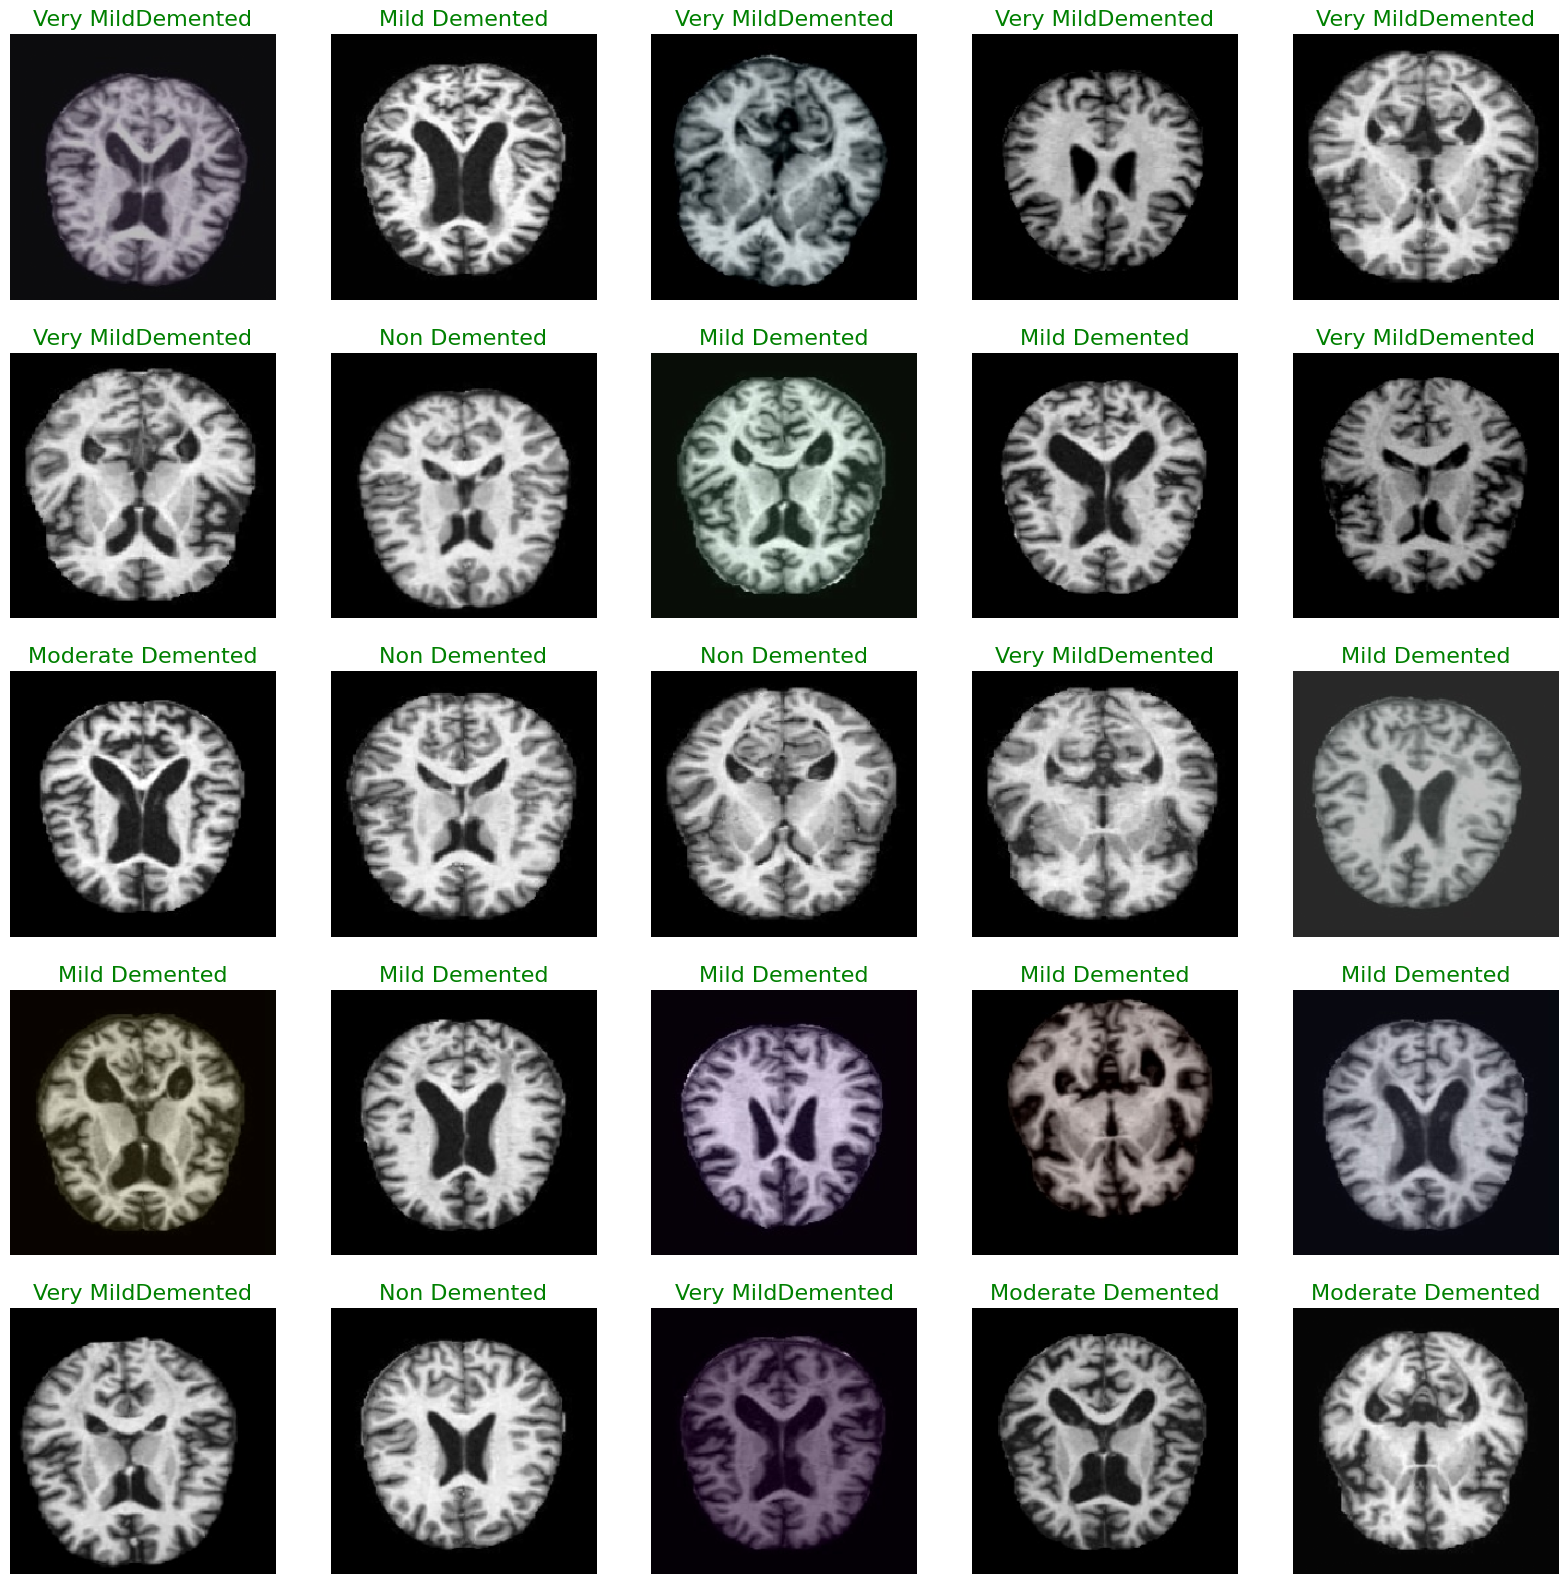

In [ ]:
show_knee_images(train)

In [ ]:
from tensorflow.keras.optimizers import Adamax

img_shape = (244, 244, 3)
base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",
                                               input_shape=img_shape, pooling='max')

for layer in base_model.layers[-30:]:
    layer.trainable = True

Inceptionv3_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])


Inceptionv3_model.compile(Adamax(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Inceptionv3_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,572 (84.17 MB)

 Trainable params: 22,031,140 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

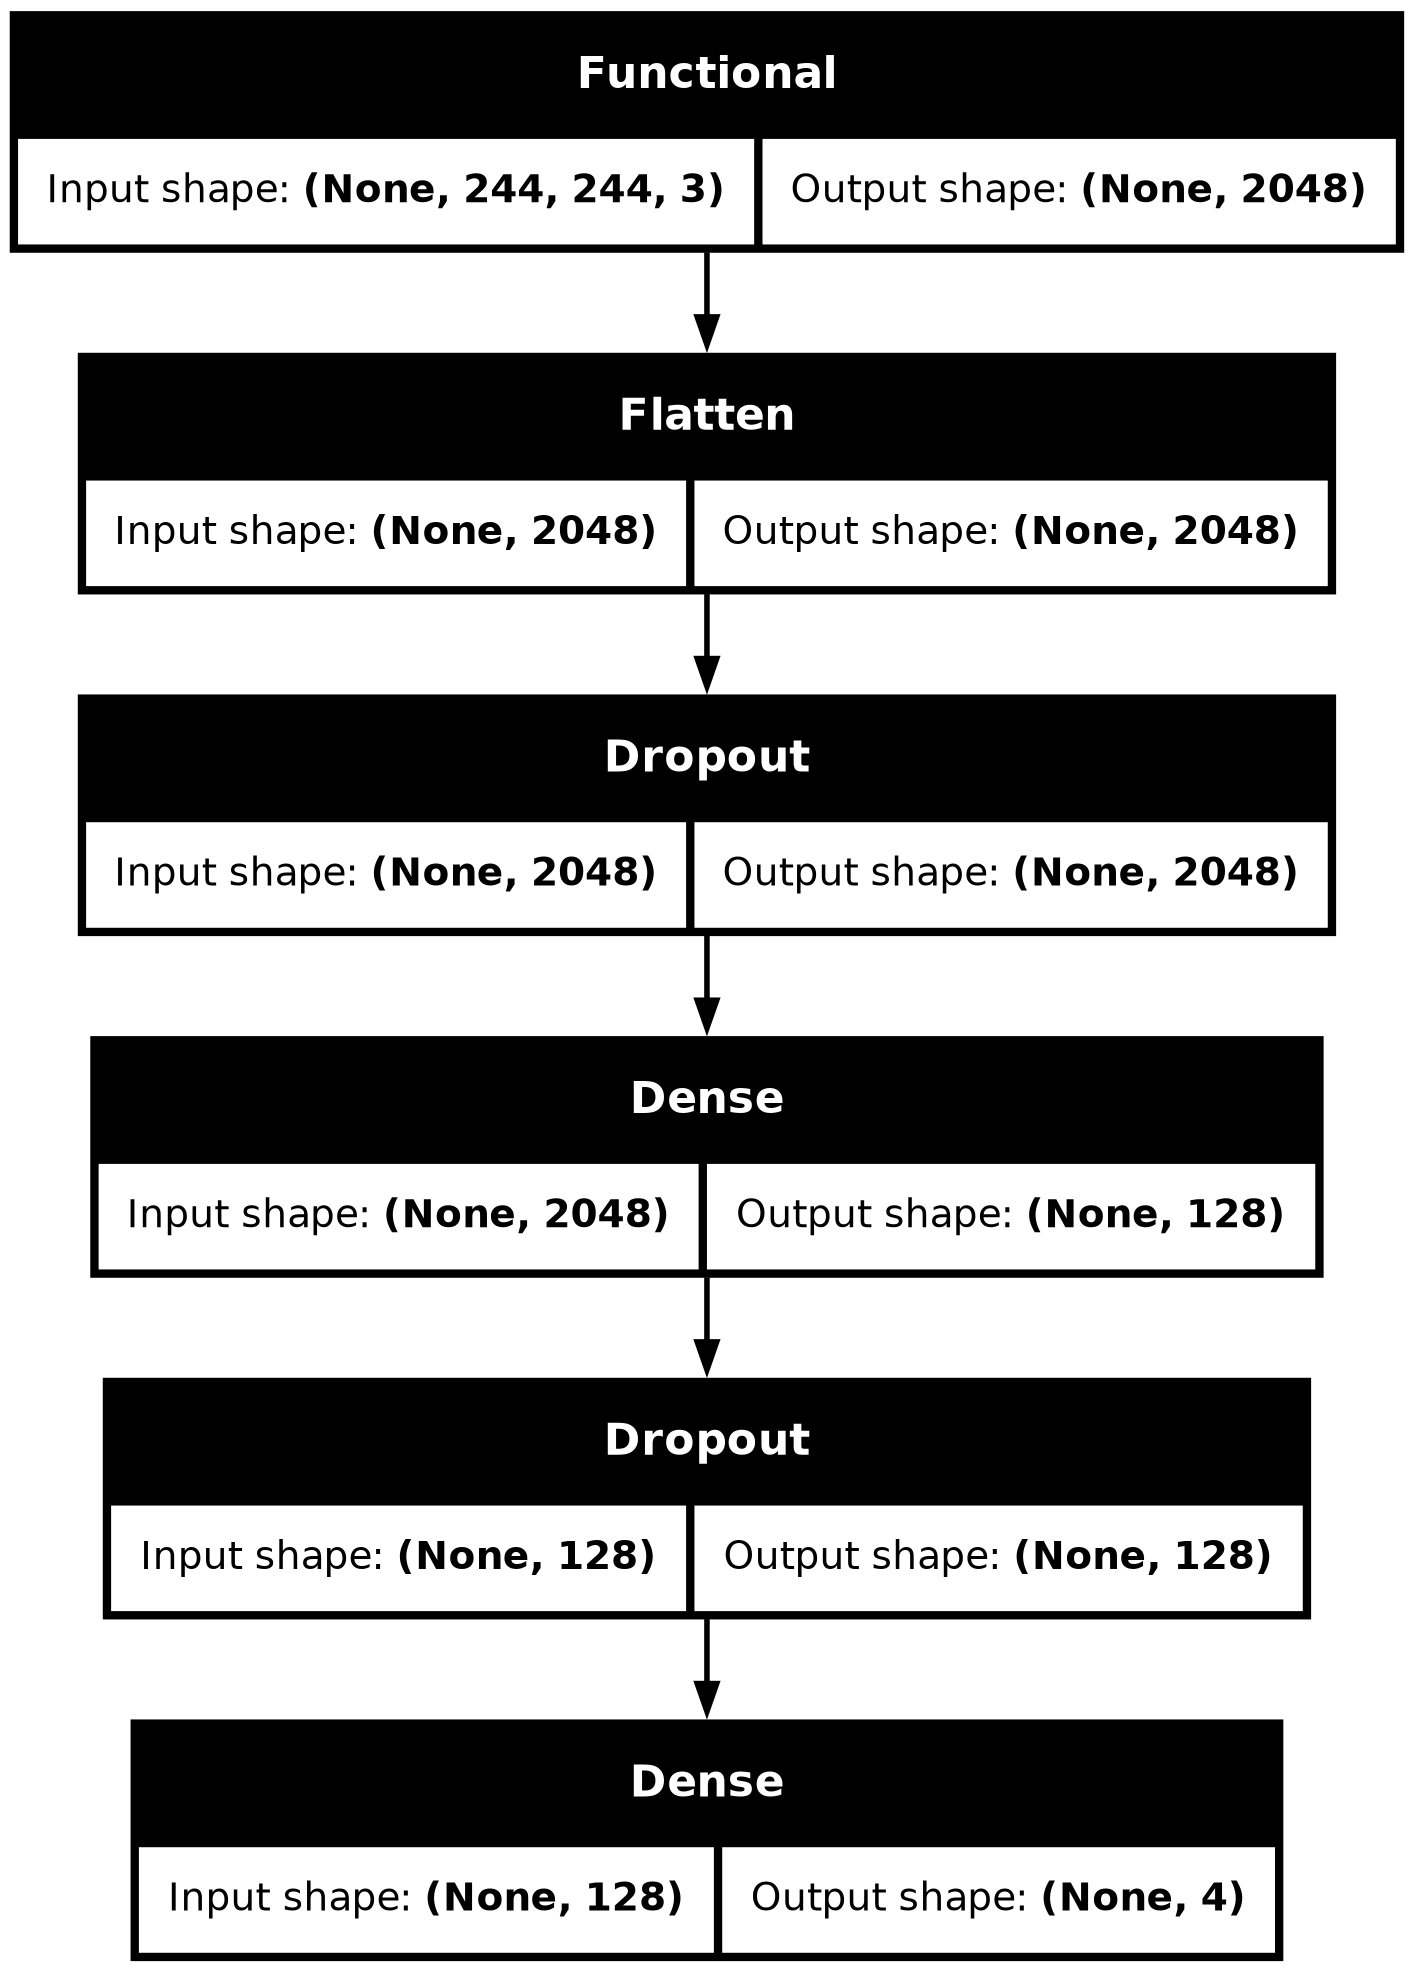

In [ ]:
Inceptionv3_model.build(input_shape=(None, *img_shape))
tf.keras.utils.plot_model(Inceptionv3_model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

def lr_schedule(epoch):
    return 0.001 * (0.9 ** epoch)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)


In [ ]:
history = Inceptionv3_model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1739542041.439135      92 service.cc:145] XLA service 0x7c570c004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739542041.439202      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1739542081.683549      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


595/595 ━━━━━━━━━━━━━━━━━━━━ 231s 269ms/step - accuracy: 0.4067 - loss: 1.6250 - val_accuracy: 0.6492 - val_loss: 0.7464
Epoch 2/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 106s 178ms/step - accuracy: 0.6470 - loss: 0.7565 - val_accuracy: 0.7045 - val_loss: 0.6095
Epoch 3/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 106s 177ms/step - accuracy: 0.7616 - loss: 0.5337 - val_accuracy: 0.7932 - val_loss: 0.4725
Epoch 4/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 107s 178ms/step - accuracy: 0.8830 - loss: 0.2892 - val_accuracy: 0.9105 - val_loss: 0.2226
Epoch 5/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 106s 177ms/step - accuracy: 0.9510 - loss: 0.1305 - val_accuracy: 0.9317 - val_loss: 0.1916
Epoch 6/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 105s 176ms/step - accuracy: 0.9750 - loss: 0.0681 - val_accuracy: 0.9344 - val_loss: 0.2210
Epoch 7/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 105s 176ms/step - accuracy: 0.9853 - loss: 0.0432 - val_accuracy: 0.9424 - val_loss: 0.1752
Epoch 8/10
595/595 ━━━━━━━━━━━━━━━━━━━━ 105s 176ms/step - accuracy: 0.9886 - loss: 0.03

In [ ]:
Inceptionv3_model.evaluate(test, verbose=1)


319/319 ━━━━━━━━━━━━━━━━━━━━ 67s 211ms/step - accuracy: 0.9606 - loss: 0.1144


[0.11749090254306793, 0.9603766202926636]

In [ ]:
train_loss, train_accuracy = Inceptionv3_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

595/595 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.9994 - loss: 0.0026

Train loss: 0.00
Train Accuracy: 99.96 %


In [ ]:
train_loss, train_accuracy = Inceptionv3_model.evaluate(val)
print(f'\nvalidation loss: {train_loss:.2f}')
print(f'Validation Accuracy: {train_accuracy*100:.2f} %')

149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9620 - loss: 0.1188

validation loss: 0.13
Validation Accuracy: 95.99 %


In [ ]:
train_loss, train_accuracy = Inceptionv3_model.evaluate(test)
print(f'\ntest loss: {train_loss:.2f}')
print(f'Test Accuracy: {train_accuracy*100:.2f} %')

319/319 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9606 - loss: 0.1144

test loss: 0.12
Test Accuracy: 96.04 %


In [ ]:
pred = Inceptionv3_model.predict(test)
pred = np.argmax(pred, axis=1)

labels = train.class_indices
labels = dict((v, k) for k, v in labels.items())
pred2 = [labels[k] for k in pred]

319/319 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step


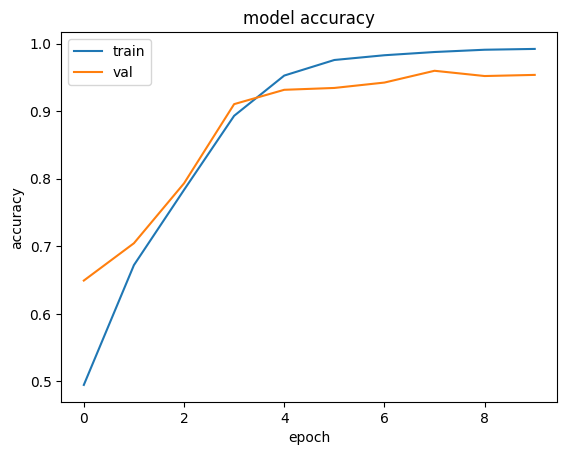

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

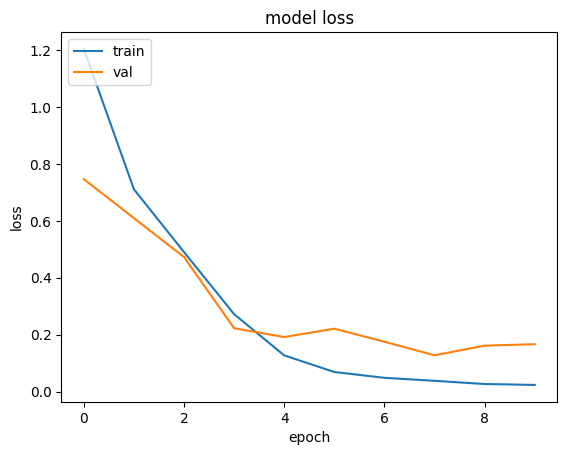

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:", "{:.1f}%".format(accuracy_score(y_test, pred2) * 100))

                   precision    recall  f1-score   support

    Mild Demented       0.97      0.98      0.97      2688
Moderate Demented       1.00      1.00      1.00      1940
     Non Demented       0.96      0.93      0.95      2880
Very MildDemented       0.92      0.95      0.94      2688

         accuracy                           0.96     10196
        macro avg       0.96      0.96      0.96     10196
     weighted avg       0.96      0.96      0.96     10196

Accuracy of the Model: 96.0%


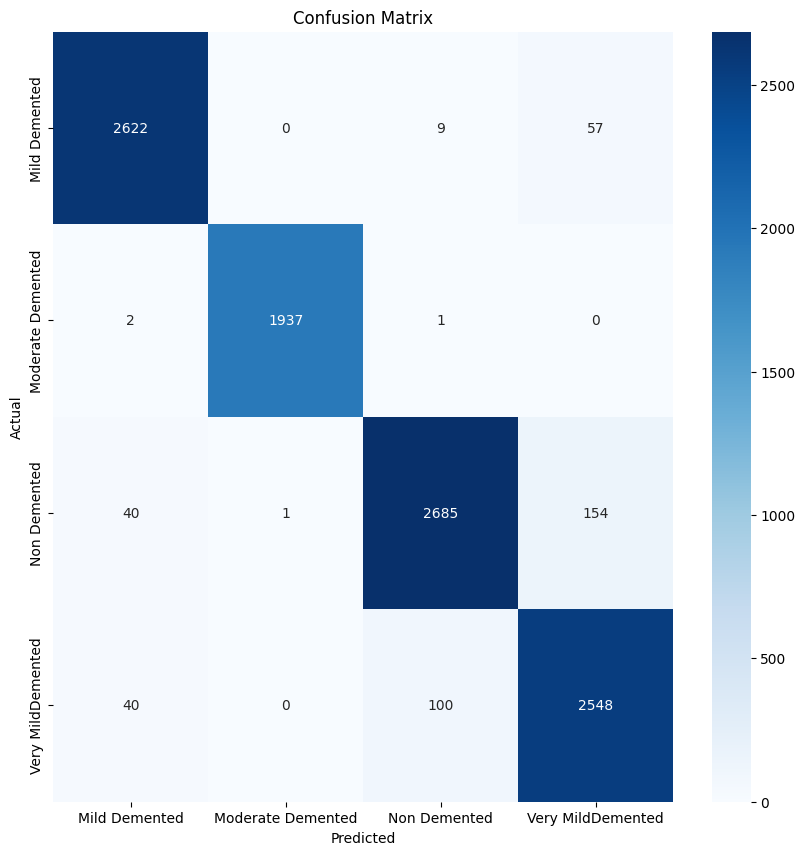

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [ ]:
# Save the entire model
Inceptionv3_model.save('inceptionv3_alzheimer_model.h5')

print("Model saved successfully!")


Model saved successfully!
